In [1]:
from data_loader import load_random_page, load_page, load_page_by_name

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = load_page_by_name('A_Song_of_Ice_and_Fire_en.wikipedia.org_desktop_all-agents')
data

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
8458,A_Song_of_Ice_and_Fire_en.wikipedia.org_deskto...,9554.0,9147.0,7235.0,6426.0,7307.0,9832.0,9219.0,8204.0,7920.0,...,3431.0,2826.0,2069.0,2204.0,3100.0,3719.0,4043.0,3841.0,3345.0,2638.0


In [3]:
# Remove first col
data = data.iloc[:, 1:]
data

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
8458,9554.0,9147.0,7235.0,6426.0,7307.0,9832.0,9219.0,8204.0,7920.0,6717.0,...,3431.0,2826.0,2069.0,2204.0,3100.0,3719.0,4043.0,3841.0,3345.0,2638.0


In [4]:
data = data.T
data

,8458
2015-07-01,9554.0
2015-07-02,9147.0
2015-07-03,7235.0
2015-07-04,6426.0
2015-07-05,7307.0
...,...
2016-12-27,3719.0
2016-12-28,4043.0
2016-12-29,3841.0
2016-12-30,3345.0


In [5]:
data = data.reset_index()
data.columns = ['date', 'views']
data

,date,views
0,2015-07-01,9554.0
1,2015-07-02,9147.0
2,2015-07-03,7235.0
3,2015-07-04,6426.0
4,2015-07-05,7307.0
...,...,...
545,2016-12-27,3719.0
546,2016-12-28,4043.0
547,2016-12-29,3841.0
548,2016-12-30,3345.0


In [6]:
data.describe()

,views
count,550.000000
mean,5720.945455
std,4333.036460
min,2069.000000
25%,3519.250000
50%,4375.500000
75%,6117.750000
max,46097.000000


In [7]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('1D')
data.head()

,views
date,
2015-07-01,9554.0
2015-07-02,9147.0
2015-07-03,7235.0
2015-07-04,6426.0
2015-07-05,7307.0


In [8]:
print(f"Missing values: {data.isnull().any(axis=1).sum()}")

Missing values: 0


The views are observed in 550 days, in the time range from 2015-07-01 to 2016-12-31. Partition it into 3 intervals for training, validation and testing.

In [9]:
end_train = '2016-06-30'
end_val = '2016-09-30'

train_df = data[:end_train]
val_df = data[end_train:end_val]
test_df = data[end_val:]

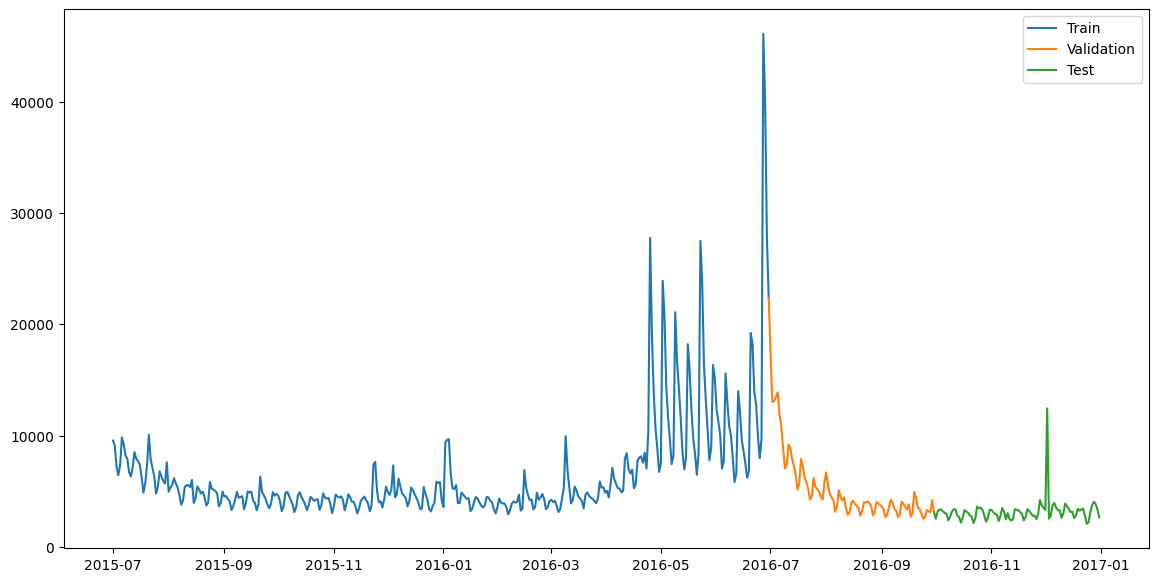

In [10]:
# Plot data
plt.figure(figsize=(14, 7))
plt.plot(train_df, label='Train')
plt.plot(val_df, label='Validation')
plt.plot(test_df, label='Test')
plt.legend()
plt.show()

In [11]:
# Find seasonality
data['weekday'] = data.index.weekday
data['monthday'] = data.index.day
data['month'] = data.index.month
data['year'] = data.index.year

data

,views,weekday,monthday,month,year
date,,,,,
2015-07-01,9554.0,2,1,7,2015
2015-07-02,9147.0,3,2,7,2015
2015-07-03,7235.0,4,3,7,2015
2015-07-04,6426.0,5,4,7,2015
2015-07-05,7307.0,6,5,7,2015
...,...,...,...,...,...
2016-12-27,3719.0,1,27,12,2016
2016-12-28,4043.0,2,28,12,2016
2016-12-29,3841.0,3,29,12,2016


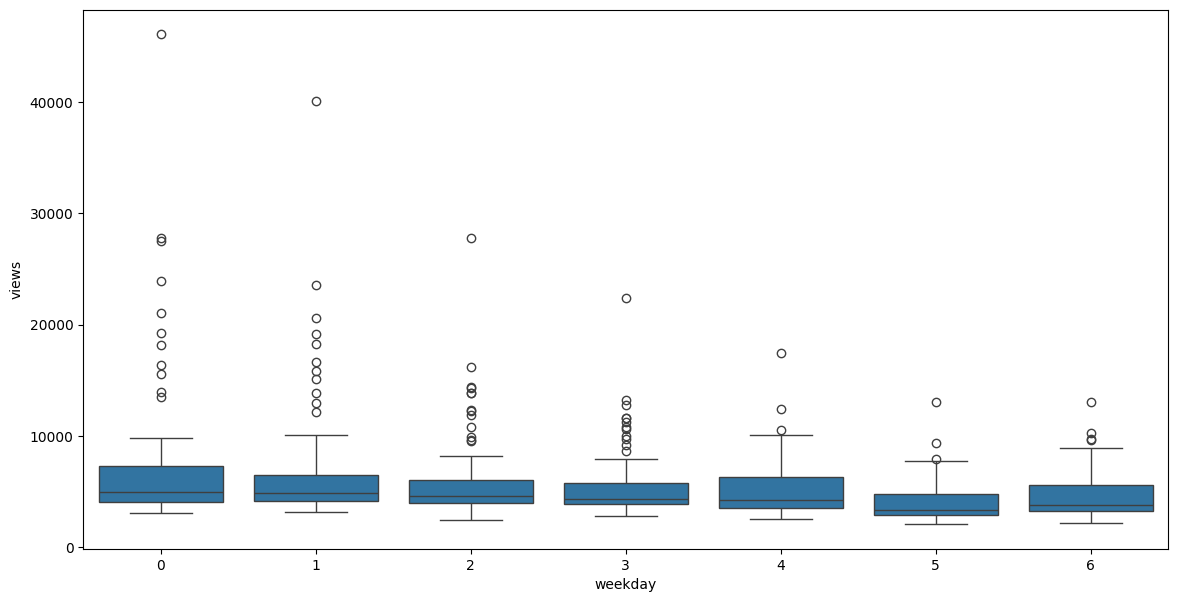

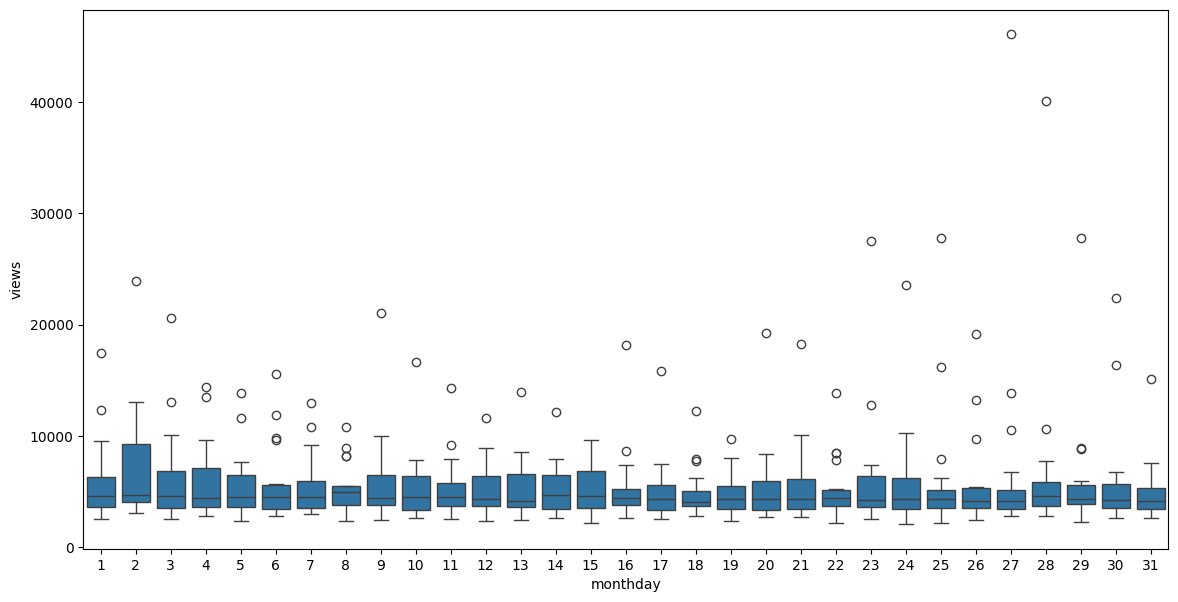

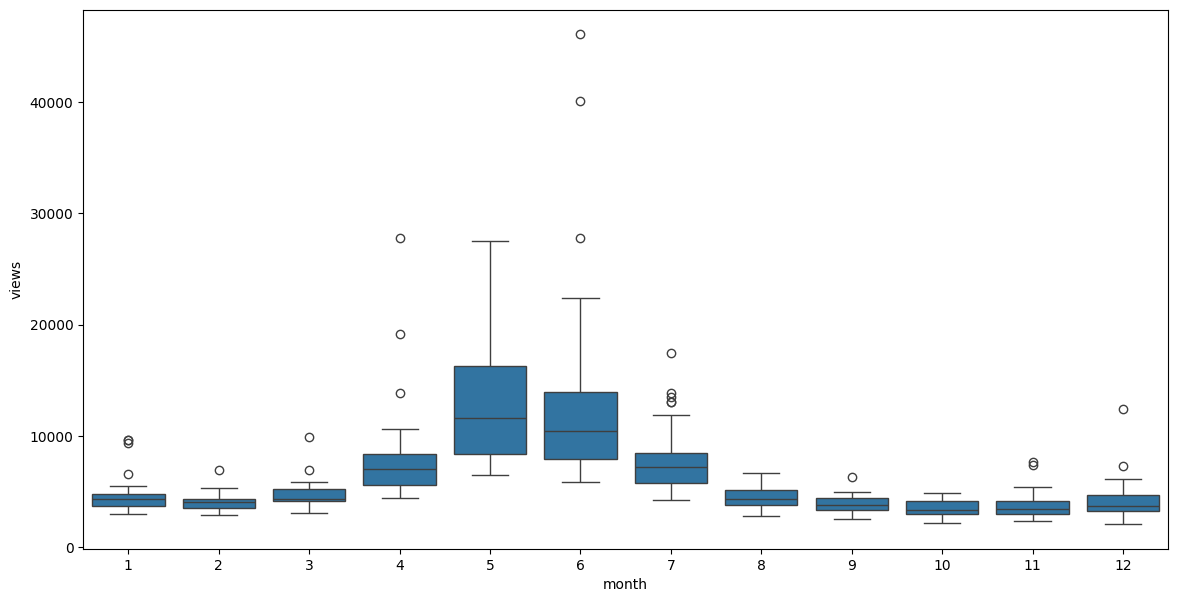

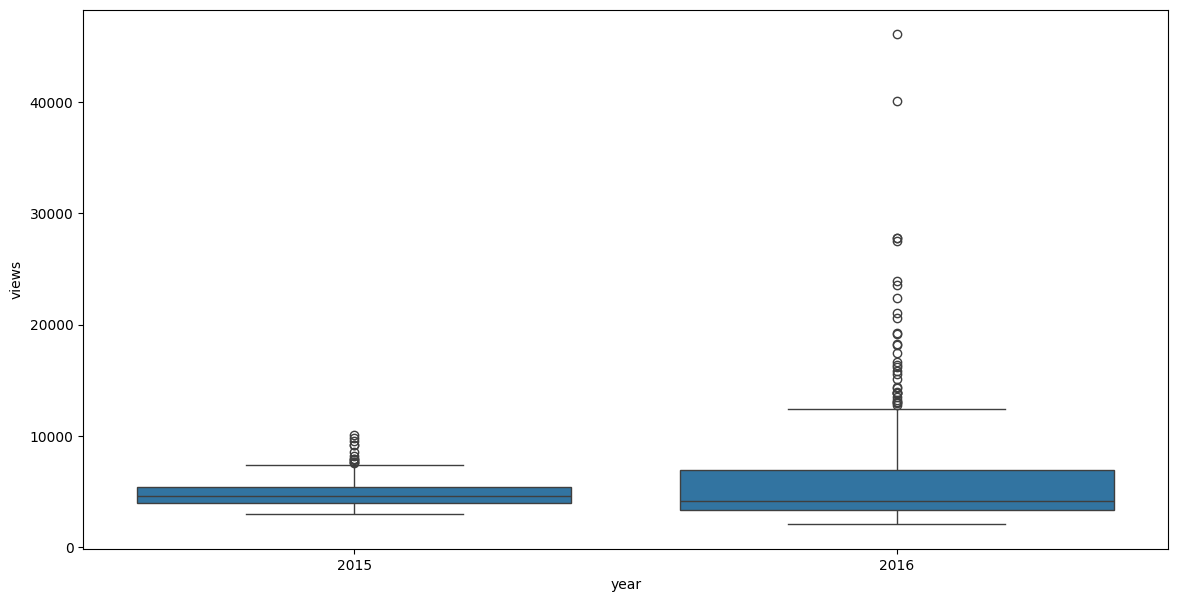

In [12]:
# Boxplots 
plt.figure(figsize=(14, 7))
sns.boxplot(data=data, x='weekday', y='views')
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(data=data, x='monthday', y='views')
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(data=data, x='month', y='views')
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(data=data, x='year', y='views')
plt.show()

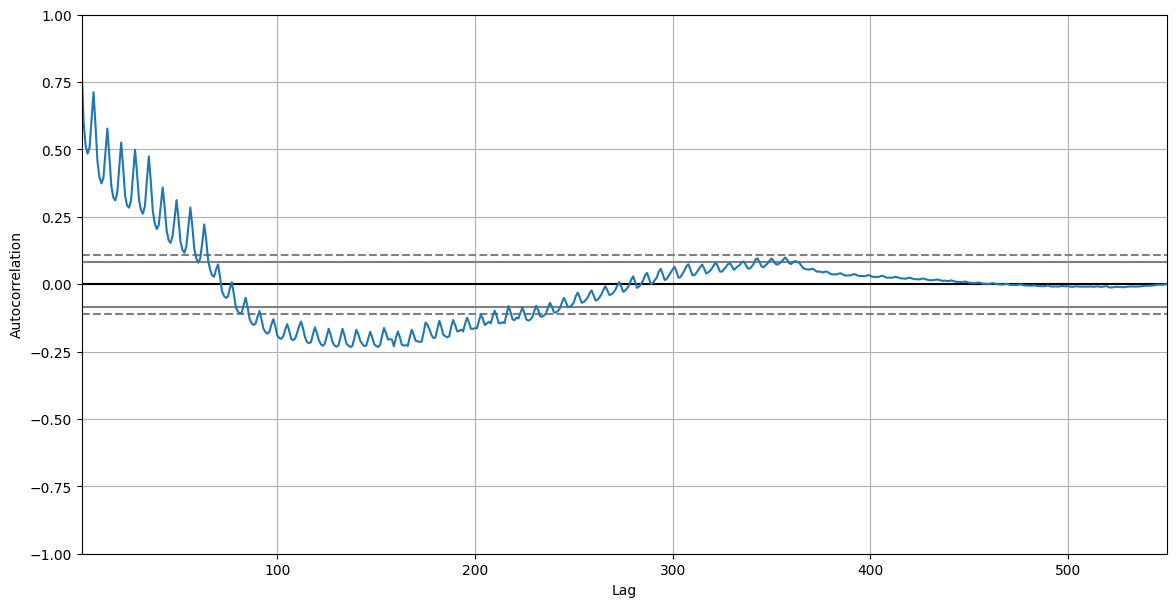

In [13]:
# Autocorrelation
plt.figure(figsize=(14, 7))
pd.plotting.autocorrelation_plot(data['views'])
plt.show()

# Baseline model

In [14]:
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.model_selection import backtesting_forecaster

/Users/tripercy/miniconda3/envs/ai-programming/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
baseline_model = ForecasterEquivalentDate(offset=pd.DateOffset(days=1), n_offsets=1)
baseline_model.fit(y=train_df)

metric_baseline, predictions = backtesting_forecaster(
    forecaster=baseline_model,
    y=data["views"],
    steps=7,
    metric="mean_absolute_error",
    initial_train_size=len(data.loc[:end_val]),
    refit=False,
    n_jobs="auto",
    verbose=False,
    show_progress=True,
)
print(f"Baseline model MAE: {metric_baseline}")

100%|██████████| 14/14 [00:00<00:00, 383.68it/s]

Baseline model MAE: 1176.2608695652175


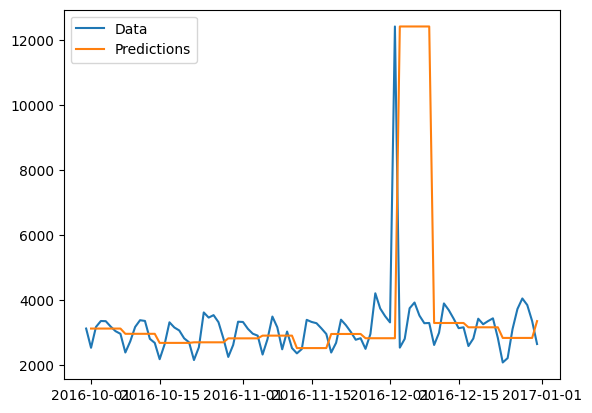

In [16]:
# Plot predictions
plt.plot(test_df["views"], label="Data")
plt.plot(predictions, label="Predictions")
plt.legend()
plt.show()

# AutoRegressive model

In [17]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.discriminant_analysis import StandardScaler

In [18]:
autoreg_model = ForecasterAutoreg(
    regressor=RandomForestRegressor(),
    lags=7,
    transformer_y=StandardScaler()
)

autoreg_model.fit(y=train_df['views'])

metric_autoreg, predictions = backtesting_forecaster(
    forecaster=autoreg_model,
    y=data["views"],
    steps=7,
    metric="mean_absolute_error",
    initial_train_size=len(data.loc[:end_val]),
    refit=False,
    n_jobs="auto",
    verbose=False,
    show_progress=True,
)
print(f"Autoreg model MAE: {metric_autoreg}")

100%|██████████| 14/14 [00:00<00:00, 55.55it/s]

Autoreg model MAE: 795.9165217391303


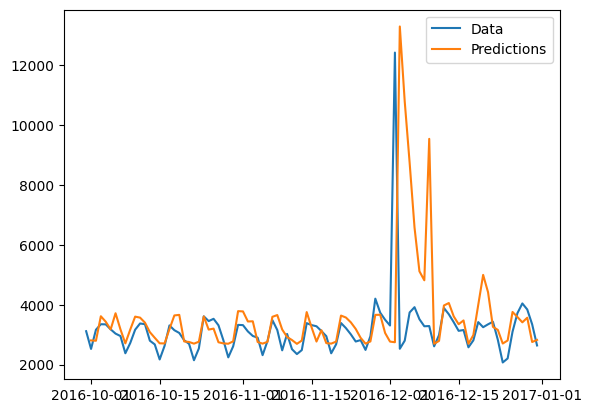

In [19]:
# Plot predictions
plt.plot(test_df["views"], label="Data")
plt.plot(predictions, label="Predictions")
plt.legend()
plt.show()

In [19]:
# Grid search
from skforecast.model_selection import grid_search_forecaster
from sklearn.linear_model import Ridge

param_grid = {'alpha': np.logspace(-3, 3, 10)}

# Lags used as predictors
lags_grid = [7, 14, 21, [7, 14, 21]]

forecaster = ForecasterAutoreg(
    regressor=Ridge(random_state=42),
    lags=14,
    forecaster_id="web_traffic",
)

results_grid_search = grid_search_forecaster(
    forecaster=forecaster,
    y=data.loc[:end_val, "views"],
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=7,
    metric="mean_absolute_error",
    refit=False,
    initial_train_size=len(train_df),
    fixed_train_size=False,
    return_best=True,
    show_progress=True,
    verbose=False,
)

Number of models compared: 40.


lags grid: 100%|██████████| 4/4 [00:00<00:00,  9.38it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 0.001}
  Backtesting metric: 1897.8032340099305



In [20]:
best_params = results_grid_search.params.iat[0]

In [21]:
mae, prediction = backtesting_forecaster(
    forecaster=forecaster,
    y=data.views,
    initial_train_size=len(data.loc[:end_val, :]),
    steps=7,
    refit=True,
    fixed_train_size=False,
    metric="mean_absolute_error",
    show_progress=False,
)
print(f"Backtest error using test data: {mae}")

Backtest error using test data: 883.7794111365611


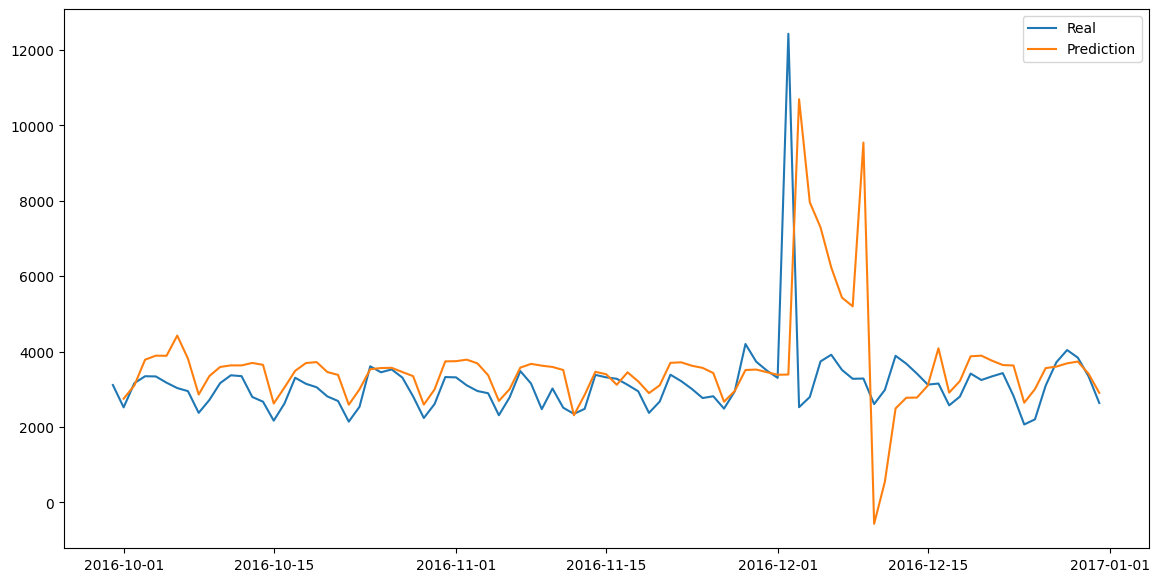

In [22]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(test_df.views, label='Real')
plt.plot(prediction.pred, label='Prediction')
plt.legend()
plt.show()

# Exogenous features

In [23]:
data['month'] = data.index.month
data['month_day'] = data.index.day
data['week_day'] = data.index.day_of_week
data['year'] = data.index.year
data.head()

,views,weekday,monthday,month,year,month_day,week_day
date,,,,,,,
2015-07-01,9554.0,2,1,7,2015,1,2
2015-07-02,9147.0,3,2,7,2015,2,3
2015-07-03,7235.0,4,3,7,2015,3,4
2015-07-04,6426.0,5,4,7,2015,4,5
2015-07-05,7307.0,6,5,7,2015,5,6


In [24]:
data.drop(["weekday", "monthday"], axis=1, inplace=True)
data.head()

,views,month,year,month_day,week_day
date,,,,,
2015-07-01,9554.0,7,2015,1,2
2015-07-02,9147.0,7,2015,2,3
2015-07-03,7235.0,7,2015,3,4
2015-07-04,6426.0,7,2015,4,5
2015-07-05,7307.0,7,2015,5,6


In [25]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder


one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        ['month', 'week_day', 'month_day', 'year'],
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

data = one_hot_encoder.fit_transform(data)
data.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,month_day_24,month_day_25,month_day_26,month_day_27,month_day_28,month_day_29,month_day_30,month_day_31,year_2016,views
date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9554.0
2015-07-02,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9147.0
2015-07-03,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7235.0
2015-07-04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6426.0
2015-07-05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7307.0


In [26]:
data.shape

(550, 52)

In [27]:
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_val, :]
data_test  = data.loc[end_val:, :]
exog_features = [col for col in data.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

In [32]:
# forecaster = ForecasterAutoreg(
#     regressor=Ridge(**best_params, random_state=42),
#     lags=14,
#     transformer_y=StandardScaler()
# )
param_grid = {'alpha': np.logspace(-3, 3, 10)}

# Lags used as predictors
lags_grid = [7, 14, 21, [7, 14, 21]]

forecaster = ForecasterAutoreg(
    regressor=Ridge(random_state=42),
    lags=14,
    transformer_y=StandardScaler(),
    forecaster_id="web_traffic",
    transformer_exog=StandardScaler()
)

results_grid_search = grid_search_forecaster(
    forecaster=forecaster,
    y=data.loc[:end_val, "views"],
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=7,
    metric="mean_absolute_error",
    refit=False,
    initial_train_size=len(train_df),
    fixed_train_size=False,
    return_best=True,
    show_progress=True,
    verbose=False,
    exog=data.loc[:end_val, exog_features],
)

mae, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data.views,
    exog=data[exog_features],
    initial_train_size=len(data.loc[:end_val, :]),
    steps=7,
    metric="mean_absolute_error",
    refit=True,
    fixed_train_size=False,
    verbose=False,
    show_progress=True,
)

print(f"Backtest error: {mae}")

Number of models compared: 40.


lags grid: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'alpha': 215.44346900318823}
  Backtesting metric: 1371.0541221778988



100%|██████████| 14/14 [00:00<00:00, 70.69it/s]

Backtest error: 968.4548458503162


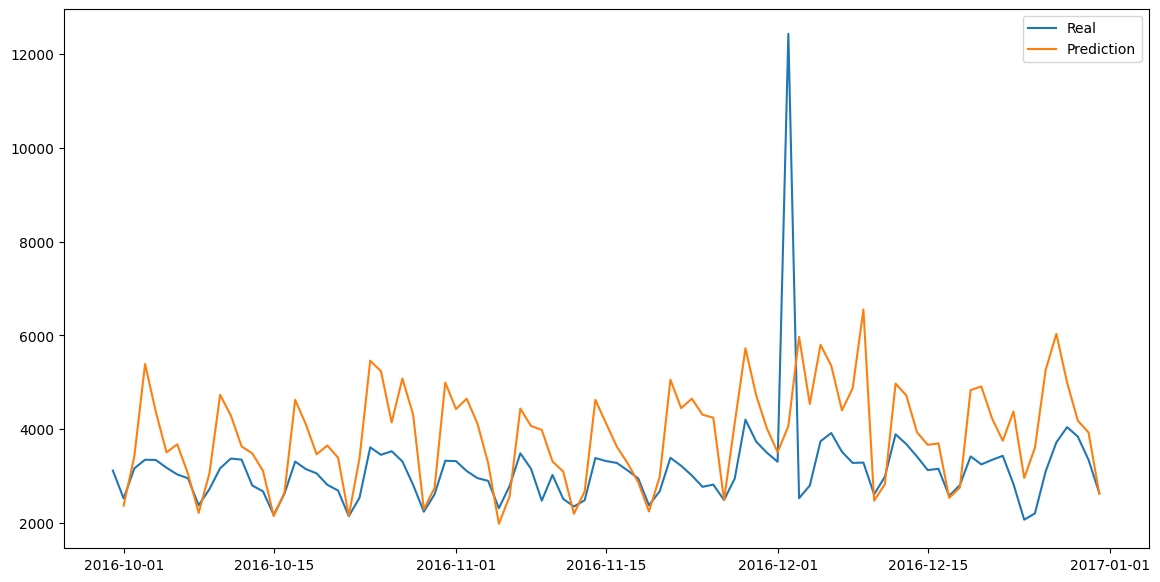

In [33]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(data_test.views, label='Real')
plt.plot(predictions.pred, label='Prediction')

plt.legend()
plt.show()

In [34]:
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data.views,
    exog=data[exog_features],
    initial_train_size=len(data.loc[:end_val]),
    steps=7,
    metric="mean_absolute_error",
    refit=True,
    fixed_train_size=False,
    interval=[10, 90],
    n_boot=250,
    verbose=False,
    show_progress=True,
)
print(f"Backtest error: {metric}")

100%|██████████| 14/14 [00:04<00:00,  3.06it/s]

Backtest error: 968.4548458503162


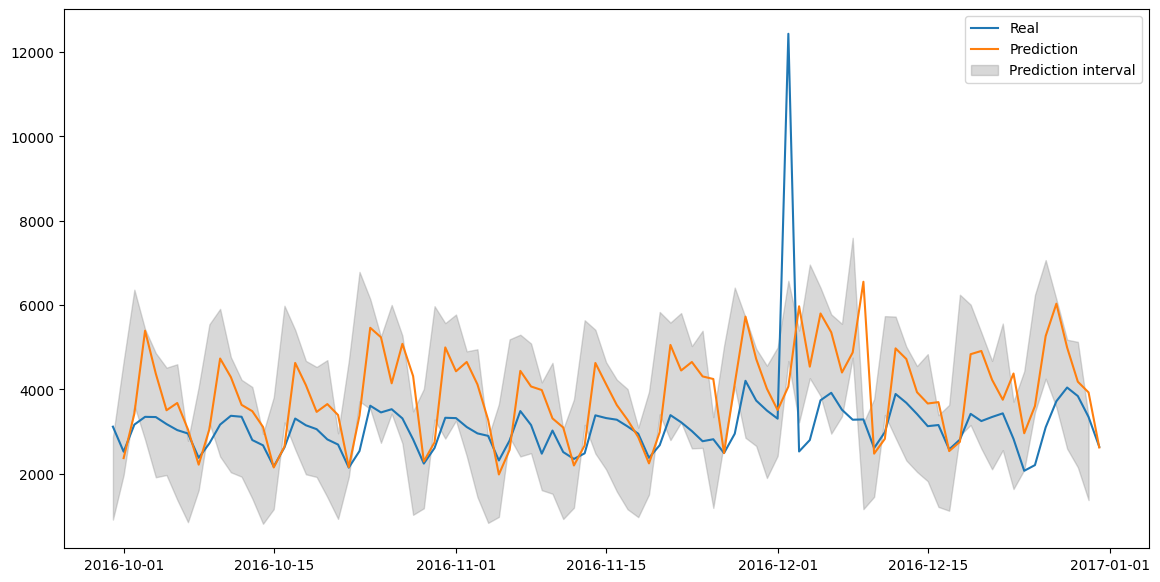

In [35]:
# Plot prediction intervals
plt.figure(figsize=(14, 7))
plt.plot(data_test.views, label='Real')
plt.plot(predictions.pred, label='Prediction')
plt.fill_between(
    data_test.index[:-1],
    predictions['lower_bound'],
    predictions['upper_bound'],
    color='gray',
    alpha=0.3,
    label='Prediction interval'
)
plt.legend()

In [36]:
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax

In [37]:
forecaster_arima = ForecasterSarimax(
    regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200)
)

In [38]:
forecaster_arima.fit(y=data[:end_val].views)

In [39]:
predictions_arima = forecaster_arima.predict(steps=62)
predictions_arima

2016-10-01    2585.945289
2016-10-02    2877.743810
2016-10-03    3410.418251
2016-10-04    3390.987393
2016-10-05    3303.270167
                 ...     
2016-11-27    3214.990024
2016-11-28    3223.673418
2016-11-29    3225.859132
2016-11-30    3245.199828
2016-12-01    3261.181513
Freq: D, Name: pred, Length: 62, dtype: float64

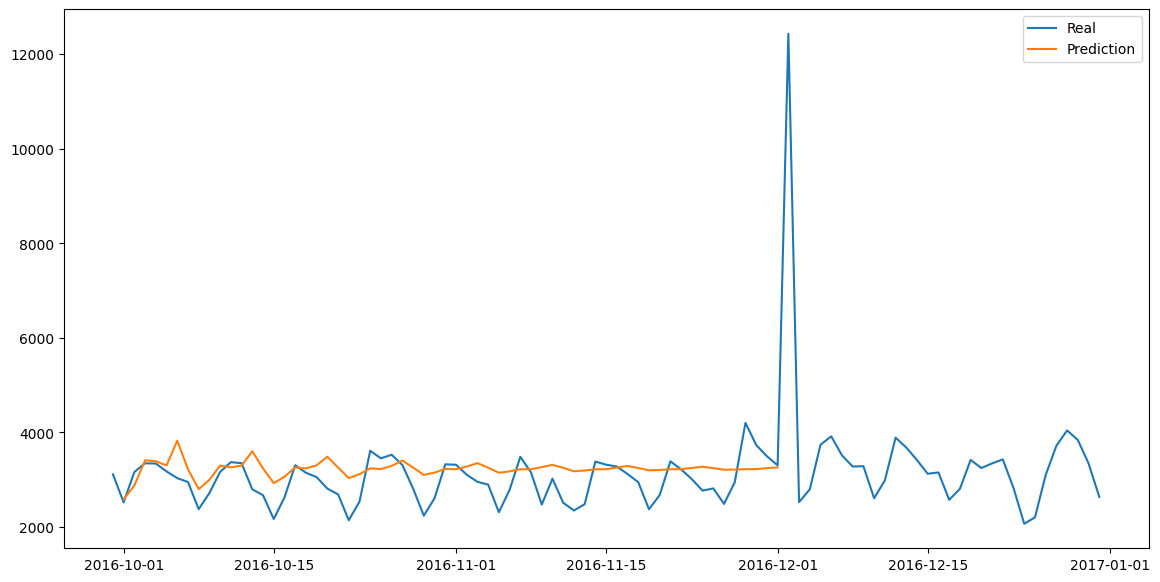

In [40]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(data[end_val:].views, label='Real')
plt.plot(predictions_arima, label='Prediction')
plt.legend()